# Work on traffic_signs

# New Model

In [45]:
# !pip install pandas
# !pip install scipy

In [1]:
# Libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import cv2
from PIL import Image
import os
from sklearn.metrics import classification_report
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [33]:
base_path = "D:\GTSRB Dataset\gtsrb\\"
save_path = "./trafficsignnet.model"
plot_path = "./plot.png"
test_path = "./Test/"
example_path = "./examples"

In [34]:
# Reading the input images and putting them into a numpy array
data=[]
labels=[]

height = 32
width = 32
channels = 1
classes = 43
n_inputs = height * width*channels
NUM_EPOCHS = 30
INIT_LR = 1e-3
BS = 64
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))

for i in range(classes) :
    path = base_path+"/train/{0}/".format(i)
    print(path)
    Class=os.listdir(path)
    for a in Class:
        try:
            image=cv2.imread(path+a)
            image = cv2.resize(image, (height, width))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = clahe.apply(image) 
            data.append(np.array(image))
            labels.append(i)
        except AttributeError:
            print("Error")
#     print(data)
Cells=np.array(data)
labels=np.array(labels)

#Randomize the order of the input images
s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

D:\GTSRB Dataset\gtsrb\/train/0/
D:\GTSRB Dataset\gtsrb\/train/1/
D:\GTSRB Dataset\gtsrb\/train/2/
D:\GTSRB Dataset\gtsrb\/train/3/
D:\GTSRB Dataset\gtsrb\/train/4/
D:\GTSRB Dataset\gtsrb\/train/5/
D:\GTSRB Dataset\gtsrb\/train/6/
D:\GTSRB Dataset\gtsrb\/train/7/
D:\GTSRB Dataset\gtsrb\/train/8/
D:\GTSRB Dataset\gtsrb\/train/9/
D:\GTSRB Dataset\gtsrb\/train/10/
D:\GTSRB Dataset\gtsrb\/train/11/
D:\GTSRB Dataset\gtsrb\/train/12/
D:\GTSRB Dataset\gtsrb\/train/13/
D:\GTSRB Dataset\gtsrb\/train/14/
D:\GTSRB Dataset\gtsrb\/train/15/
D:\GTSRB Dataset\gtsrb\/train/16/
D:\GTSRB Dataset\gtsrb\/train/17/
D:\GTSRB Dataset\gtsrb\/train/18/
D:\GTSRB Dataset\gtsrb\/train/19/
D:\GTSRB Dataset\gtsrb\/train/20/
D:\GTSRB Dataset\gtsrb\/train/21/
D:\GTSRB Dataset\gtsrb\/train/22/
D:\GTSRB Dataset\gtsrb\/train/23/
D:\GTSRB Dataset\gtsrb\/train/24/
D:\GTSRB Dataset\gtsrb\/train/25/
D:\GTSRB Dataset\gtsrb\/train/26/
D:\GTSRB Dataset\gtsrb\/train/27/
D:\GTSRB Dataset\gtsrb\/train/28/
D:\GTSRB Dataset\gtsrb\/

In [35]:
#Spliting the images into train and validation sets
(X_train,X_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]
X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255
(y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]

#Using one hote encoding for the train and validation labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [36]:
#accounting for the skewed classes
classTotals = y_train.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

In [37]:
X_train.shape

(31368, 32, 32)

In [38]:
X_val.shape

(7841, 32, 32)

In [39]:
X_train = X_train[:,:,:,np.newaxis]
X_val = X_val[:,:,:,np.newaxis]
# teX = testX[:,:,:,np.newaxis]
# teX = testX[:,:,:,np.newaxis]

In [40]:
X_train.shape

(31368, 32, 32, 1)

In [41]:
#Definition of the DNN model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

# #Compilation of the model
# model.compile(
#     loss='categorical_crossentropy', 
#     optimizer='adam', 
#     metrics=['accuracy']
# )

In [42]:
import scipy 
#data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# initialize and compiiling
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
# model = TrafficSignNet.build(width=32, height=32, depth=1,
#         classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt,
        metrics=["accuracy"])

#early callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=5,
                                            restore_best_weights=True)

# train the network
print("[INFO] training network...")
history = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    validation_data=(X_val, y_val),
    steps_per_epoch=X_train.shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    callbacks=[callback],
    verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/30
490/490 [==============================] - 55s 112ms/step - loss: 6.3024 - acc: 0.2741 - val_loss: 0.7327 - val_acc: 0.7694
Epoch 2/30
490/490 [==============================] - 55s 111ms/step - loss: 2.6249 - acc: 0.6396 - val_loss: 0.2343 - val_acc: 0.9443
Epoch 3/30
490/490 [==============================] - 55s 111ms/step - loss: 1.7961 - acc: 0.7421 - val_loss: 0.1792 - val_acc: 0.9577
Epoch 4/30
490/490 [==============================] - 54s 111ms/step - loss: 1.3622 - acc: 0.7979 - val_loss: 0.1137 - val_acc: 0.9736
Epoch 5/30
490/490 [==============================] - 54s 111ms/step - loss: 1.1234 - acc: 0.8334 - val_loss: 0.0782 - val_acc: 0.9810
Epoch 6/30
490/490 [==============================] - 54s 110ms/step - loss: 0.9781 - acc: 0.8570 - val_loss: 0.0668 - val_acc: 0.9835
Epoch 7/30
490/490 [==============================] - 54s 111ms/step - loss: 0.8472 - acc: 0.8786 - val_loss: 0.0581 - val_acc: 0.9833
Ep

490/490 [==============================] - 56s 115ms/step - loss: 0.5753 - acc: 0.9140 - val_loss: 0.0340 - val_acc: 0.9893
Epoch 12/30
490/490 [==============================] - 56s 115ms/step - loss: 0.5269 - acc: 0.9214 - val_loss: 0.0332 - val_acc: 0.9897
Epoch 13/30
490/490 [==============================] - 54s 111ms/step - loss: 0.4927 - acc: 0.9275 - val_loss: 0.0274 - val_acc: 0.9922
Epoch 14/30
490/490 [==============================] - 55s 112ms/step - loss: 0.4625 - acc: 0.9312 - val_loss: 0.0230 - val_acc: 0.9935
Epoch 15/30
490/490 [==============================] - 55s 113ms/step - loss: 0.4411 - acc: 0.9342 - val_loss: 0.0255 - val_acc: 0.9923
Epoch 16/30
490/490 [==============================] - 55s 112ms/step - loss: 0.4070 - acc: 0.9391 - val_loss: 0.0203 - val_acc: 0.9926
Epoch 17/30
490/490 [==============================] - 56s 114ms/step - loss: 0.3955 - acc: 0.9412 - val_loss: 0.0205 - val_acc: 0.9944
Epoch 18/30
490/490 [==============================] - 55s 1

490/490 [==============================] - 58s 118ms/step - loss: 0.3180 - acc: 0.9521 - val_loss: 0.0172 - val_acc: 0.9946
Epoch 23/30
490/490 [==============================] - 58s 118ms/step - loss: 0.2911 - acc: 0.9540 - val_loss: 0.0140 - val_acc: 0.9960
Epoch 24/30
490/490 [==============================] - 54s 111ms/step - loss: 0.2872 - acc: 0.9557 - val_loss: 0.0145 - val_acc: 0.9955
Epoch 25/30
490/490 [==============================] - 45s 91ms/step - loss: 0.2885 - acc: 0.9575 - val_loss: 0.0138 - val_acc: 0.9954
Epoch 26/30
490/490 [==============================] - 43s 87ms/step - loss: 0.2630 - acc: 0.9582 - val_loss: 0.0125 - val_acc: 0.9962
Epoch 27/30
490/490 [==============================] - 43s 87ms/step - loss: 0.2651 - acc: 0.9598 - val_loss: 0.0124 - val_acc: 0.9958
Epoch 28/30
490/490 [==============================] - 43s 88ms/step - loss: 0.2627 - acc: 0.9610 - val_loss: 0.0143 - val_acc: 0.9958
Epoch 29/30
490/490 [==============================] - 43s 88ms/

In [43]:
# #using ten epochs for the training and saving the accuracy for each epoch
# epochs = 20
# history = model.fit(X_train, y_train, batch_size=32, epochs=epochs,
# validation_data=(X_val, y_val))

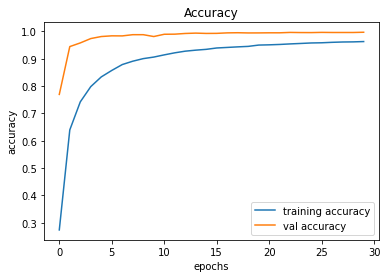

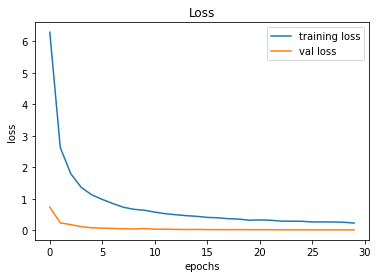

In [43]:
#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [45]:
#Predicting with the test data
y_test=pd.read_csv(base_path+"Test.csv")
labels=y_test['Path'].values
y_test=y_test['ClassId'].values


data=[]

for f in labels:
    image=cv2.imread(base_path+f)
    image = cv2.resize(image, (height, width))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = clahe.apply(image) 
    data.append(np.array(image))

testX=np.array(data)
testX = testX[:,:,:,np.newaxis]
testX = testX.astype('float32')/255 
pred = model.predict(testX)

In [46]:
pred = np.argmax(pred,axis=1)

In [47]:
#Accuracy with the test data
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.9859857482185274

In [48]:
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

In [50]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX)
print(classification_report(y_test,pred, target_names=labelNames))

# save the network
timestr = time.strftime("%Y%m%d-%H%M%S")
print("[INFO] serializing network to '{}.{}'...".format(save_path,timestr))
# save_path = os.path.sep.join(save_path,)
model.save(os.path.join(save_path,timestr))
# tf.keras.models.save_model(model,os.path.sep.join([save_path,timestr]))

[INFO] evaluating network...
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.97      1.00      0.98        60
                              Speed limit (30km/h)       0.99      1.00      1.00       720
                              Speed limit (50km/h)       0.99      0.98      0.99       750
                              Speed limit (60km/h)       0.98      0.95      0.97       450
                              Speed limit (70km/h)       1.00      0.99      0.99       660
                              Speed limit (80km/h)       0.95      0.98      0.97       630
                       End of speed limit (80km/h)       0.99      0.99      0.99       150
                             Speed limit (100km/h)       1.00      0.99      1.00       450
                             Speed limit (120km/h)       0.99      0.99      0.99       450
                                        No passing

# Tester to load YOLO model and run detection and classification

In [3]:
# import the necessary packages
from tensorflow.keras.models import load_model
from skimage import transform
from skimage import exposure
from skimage import io
from imutils import paths
import numpy as np
import argparse
import imutils
import random
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [4]:
#function to plot an image
def plot_img(image, label="image",size=[6.4,4.8]):
    plt.figure(figsize=size)
    plt.axis(False)
    plt.title(label)
    plt.imshow(image)
    return

In [5]:
#function to predict label for each input box

def predict_label(model, roi, labelNames):
    try:
        image = cv2.resize(roi,(32, 32))
    except:
        return "0"
    image = image[np.newaxis,:,:,np.newaxis]
    image = np.array(image).astype("float32") / 255.0
    
    # make predictions
    preds = model.predict(image)
    if np.max(preds)>0.75:
        j = preds.argmax(axis=1)[0]
        label = labelNames[j]
    else:
        label = "others"
    
    return label

In [20]:
#function to draw boxes and labels on the first input image

def detected_image(image_path, bbs, labels):
#     image = io.imread(image_path)
    image=image_path
    for box,label in zip(bbs,labels):
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3])), [172 , 10, 127], 2)
        cv2.putText(image, label, (int(box[0] + box[2]), int(box[1] + box[3])), cv2.FONT_HERSHEY_DUPLEX,0.75, (255, 255, 0), 2)
        
    return image

In [21]:
#function to crop box
def crop_roi(image,box):
    h, w = image.shape[:2]
    x_center, y_center = (box[0] * w), (box[1] * h)
    box_width, box_height = (box[2] * w), (box[3] * h)
    x_min, y_min = (x_center - box_width/2), (y_center - box_height/2)
    roi = image[int(y_min):int(y_min+box_height), int(x_min):int(x_min+box_width)]
    return roi, [x_min, y_min,box_width, box_height]

In [22]:
image_path = "D:\\GTSRB Dataset\\gtsrb\\test_input\\frame472.jpg"
output_path = "D:\\GTSRB Dataset\\gtsrb\\test_output"
model_name = "D:\\GTSRB Dataset\\gtsrb\\trafficsignnet.model\\20220117-180435"

[INFO] loading model...


True

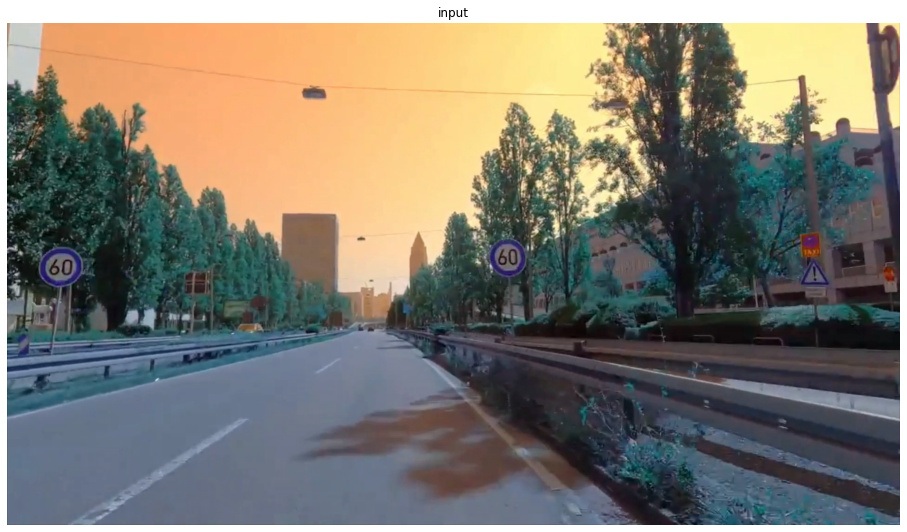

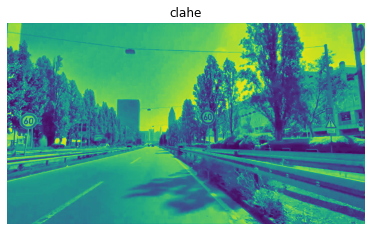

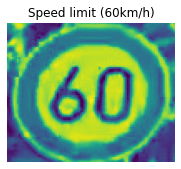

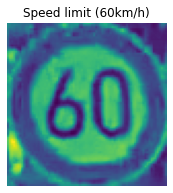

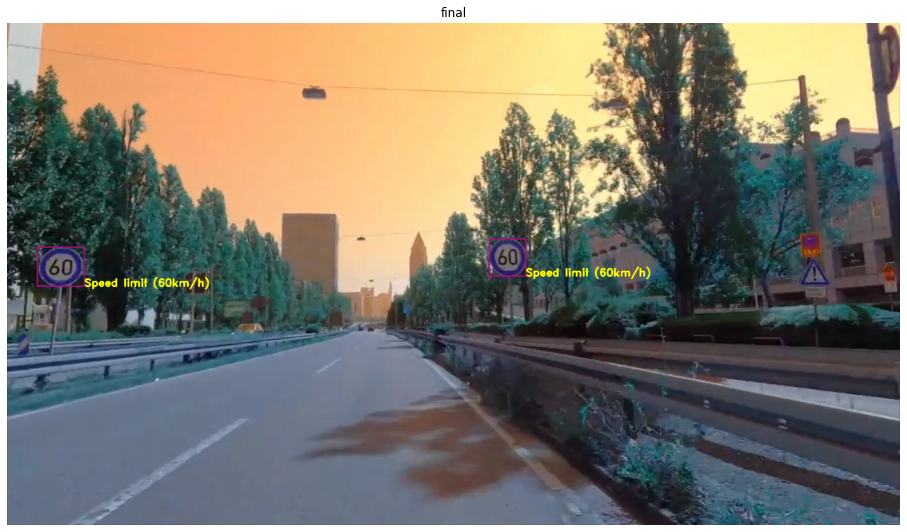

In [24]:
class_ids = []
confidences = []
boxes = []
rois = []
labels = []
bbs=[]

print("[INFO] loading model...")
model = load_model(model_name)

#yolo setup
net = cv2.dnn.readNet("yolov4-tiny_training_last_alz.weights", "yolov4-tiny_training.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
# print(output_layers)
confidence_threshold = 0.5

#forward pass yolo
image = cv2.imread(image_path)
frame = image
plot_img(image, "input", [16,12])
blob = cv2.dnn.blobFromImage(image, 0.004, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

# image=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = clahe.apply(image)
plot_img(image, "clahe") #greyscale plot incorrect due to matplotlib plot, check image_path folder for b/w image
cv2.imwrite(image_path+'_bw1'+'.jpg',image)

for out in outs:
    for detection in out:
        confidence = np.max(detection[5:])
        if confidence > confidence_threshold:
            roi, box = crop_roi(image,detection)
            confidences.append(float(confidence))
            rois.append(roi)
            boxes.append(box)

#adjust overlaps
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

for i,roi in enumerate(rois):
    if i in indexes:
        label = predict_label(model, roi,labelNames)
        plot_img(roi, label,[3,3])
        labels.append(label)
        bbs.append(boxes[i])
        
image = detected_image(frame, bbs, labels)    
plot_img(image, "final", [16,12])
cv2.imwrite(os.path.join(output_path,image_path.split("\\")[-1]),image)

# Video Tester

In [36]:
video_path = "D:\\GTSRB Dataset\\gtsrb\\video_input\\munich.mp4"
output_path = "D:\\GTSRB Dataset\\gtsrb\\video_output\\new_model"
model_name = "D:\\GTSRB Dataset\\gtsrb\\trafficsignnet.model\\20220117-180435"
path = os.path.join(output_path,video_path.split("\\")[-1])
os.makedirs(path, exist_ok=True)

In [37]:
cap = cv2.VideoCapture(video_path)
curr_frame = 0
skip_frame = 2

model = load_model(model_name)

#yolo setup
net = cv2.dnn.readNet("yolov4-tiny_training_last_alz.weights", "yolov4-tiny_training.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
confidence_threshold = 0.5

# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
total_time = time.time()

In [38]:
# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

In [39]:
while(True):
        ret, frame = cap.read()
        if not ret:
            break
        elif np.count_nonzero(np.array(frame.shape))<3:
            continue
        curr_frame+=1
        if curr_frame%skip_frame == 0:
            try:
                start_time = time.time()
                # curr_frame +=1
                # image_path = 'captured_frames/frame'+str(curr_frame)+'.jpg'
                # cv2.imwrite(image_path,frame)
                #         img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # print ("Set 3: ", str(round(time.time(), 2)))
                confidences = []
                boxes = []
                rois = []
                labels = []
                bbs=[]


                #forward pass yolo
                blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
                net.setInput(blob)
                outs = net.forward(output_layers)

                #reading again since classfier performing better on skimage
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                image = clahe.apply(image) 
                # image=cv2.imwrite(image_path, image)
              
                for out in outs:
                    for detection in out:
                        confidence = np.max(detection[5:])

                        if confidence > confidence_threshold:
                            roi, box = crop_roi(image,detection)
                            confidences.append(float(confidence))
                            rois.append(roi)
                            boxes.append(box)

                #adjust overlaps
                indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

                for i,roi in enumerate(rois):
                    if i in indexes:
                        label = predict_label(model, roi, labelNames)
                        labels.append(label)
                        bbs.append(boxes[i])

                image = detected_image(frame, bbs, labels)    
                cv2.imwrite(path+"\\frame"+str(curr_frame)+'.jpg',image)
                elapsed_time = time.time() - start_time
                fps = 1/elapsed_time
                print ("frame", curr_frame)
                print ("fps: ", str(round(fps, 2)))
            except ValueError:
                continue
            except KeyboardInterrupt:
                print ("avg fps: ", (curr_frame/skip_frame)/(time.time() - total_time))
                cap.release()
                cv2.destroyAllWindows()
                sys.exit(0)

cap.release()
cv2.destroyAllWindows()

frame 2
fps:  1.87
frame 4
fps:  11.76
frame 6
fps:  11.42
frame 8
fps:  10.87
frame 10
fps:  12.24
frame 12
fps:  11.72
frame 14
fps:  11.83
frame 16
fps:  10.65
frame 18
fps:  10.13
frame 20
fps:  10.99
frame 22
fps:  12.83
frame 24
fps:  10.64
frame 26
fps:  10.45
frame 28
fps:  10.9
frame 30
fps:  10.96
frame 32
fps:  12.97
frame 34
fps:  10.76
frame 36
fps:  11.11
frame 38
fps:  11.2
frame 40
fps:  12.17
frame 42
fps:  11.37
frame 44
fps:  11.9
frame 46
fps:  11.9
frame 48
fps:  11.28
frame 50
fps:  12.0
frame 52
fps:  12.73
frame 54
fps:  10.49
frame 56
fps:  12.49
frame 58
fps:  12.19
frame 60
fps:  12.66
frame 62
fps:  12.5
frame 64
fps:  14.08
frame 66
fps:  12.4
frame 68
fps:  13.62
frame 70
fps:  12.8
frame 72
fps:  14.22
frame 74
fps:  12.0
frame 76
fps:  13.36
frame 78
fps:  11.6
frame 80
fps:  14.95
frame 82
fps:  12.8
frame 84
fps:  10.67
frame 86
fps:  12.8
frame 88
fps:  12.8
frame 90
fps:  10.6
frame 92
fps:  11.36
frame 94
fps:  11.36
frame 96
fps:  11.9
frame 98
fps

NameError: name 'sys' is not defined

In [ ]:
# video_path = "D:\\GTSRB Dataset\\gtsrb\\video_input\\munich.mp4"
# output_path = "D:\\GTSRB Dataset\\gtsrb\\video_output"
# model_name = "./trafficsignnet.model"

In [ ]:
# path = os.path.join(output_path,video_path.split("\\")[-1])
# os.makedirs(path, exist_ok=True)
# print(path+"\\frame"+str(curr_frame))
# io.imsave(path+"\\frame"+str(curr_frame),image)